In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days)

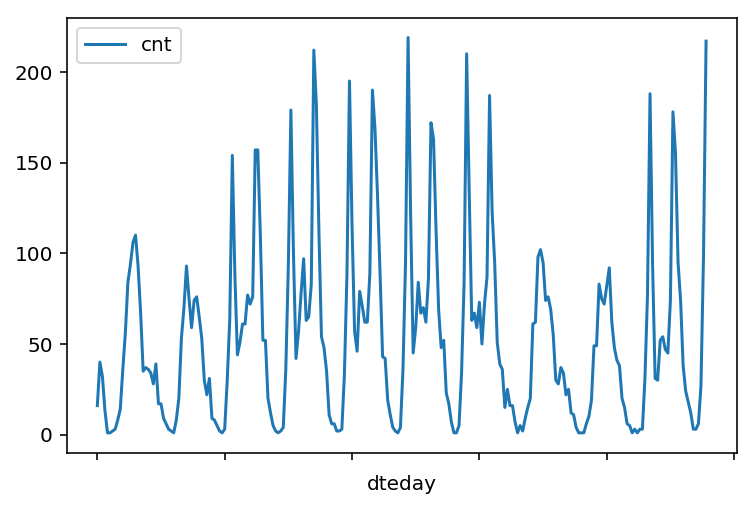

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

In [7]:
# Save data for approximately the last 21 days as a test set
test_data = data[-21*24:]

# Remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Build the network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$.

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### Set self.activation_function to a sigmoid function ####
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # The forward pass function is below
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            # The backproagation function is below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        ### Forward pass ###
        # Hidden layer
        # signals into hidden layer
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
        # signals from hidden layer
        hidden_outputs =  self.activation_function(hidden_inputs) 

        # Output layer
        # signals into final output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        # signals from final output layer
        final_outputs = final_inputs 
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        # Output error
        error = y - final_outputs
        
        # Backpropagated error terms
        output_error_term = error
        
        # Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
        
        # Backpropagated error terms
        hidden_error_term = hidden_error.reshape(1,len(hidden_error)) * (hidden_outputs) * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += np.dot(X.reshape(len(X),1), hidden_error_term)
        # Weight step (hidden to output)
        delta_weights_h_o += np.dot(hidden_outputs.reshape(len(hidden_outputs),1), output_error_term.reshape(1,len(output_error_term)))
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        # update hidden-to-output weights with gradient descent step
        self.weights_hidden_to_output +=  delta_weights_h_o * self.lr / n_records 
        # update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += delta_weights_i_h * self.lr / n_records 

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Forward pass here ####
        # Hidden layer
        # signals into hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        # signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        # Output layer
        # signals into final output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) 
        # signals from final output layer 
        final_outputs = final_inputs 
        
        return final_outputs


In [10]:
# Set hyperparameters
iterations = 12000
learning_rate = 0.15
hidden_nodes = 20
output_nodes = 1

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

In [12]:
import sys

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.0% ... Training loss: 0.902 ... Validation loss: 1.887

C:\Users\32297\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Progress: 100.0% ... Training loss: 0.078 ... Validation loss: 0.154

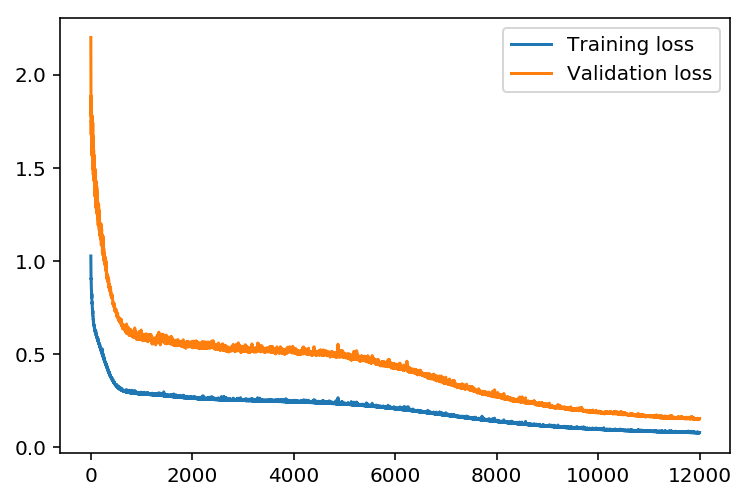

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Use test data to check out predictions

C:\Users\32297\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


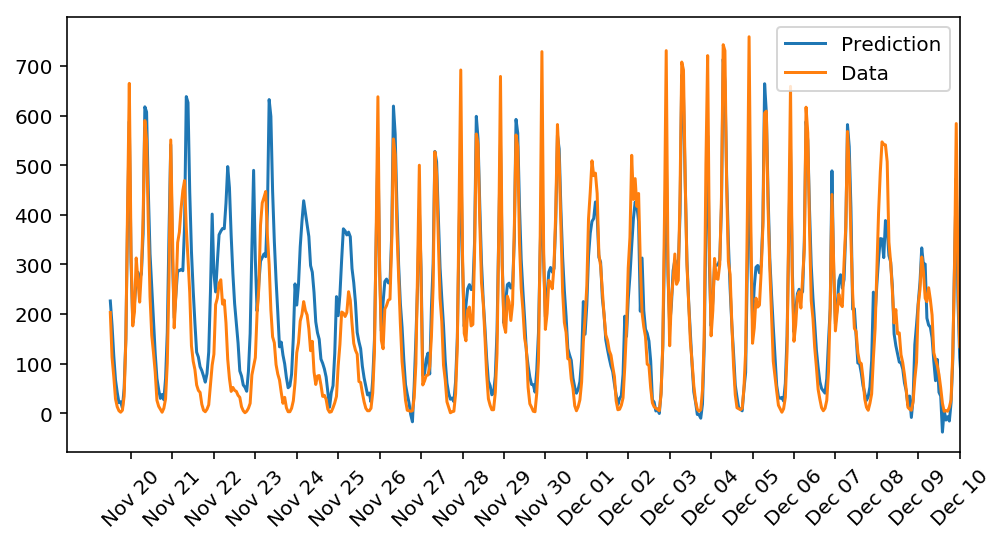

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

# Comment
Overall the model seems to predict the data well. The model fails mainly on the latter half of the month, and it may be because of it being a holiday season. This period is marked as "holiday" like other holidays, but people may use bikes more often during Christmas than during other holidays. 

To improve the prediction, I could probably create another variable that shows the level of holidays. For example, if the bike demand during a holiday season, like Christmas, is above certain value, it could be rendered a level of "2" under the "holiday" attribute. Then, of course, create a dummy variable accordingly. 